# Exoplanet Classification using NASA Datasets (Kepler, K2, and TESS)

**Mission-agnostic** classifier for **CONFIRMED / CANDIDATE / FALSE POSITIVE** using Kepler, K2, and TESS catalogs.  
This version **guarantees** an SNR-like feature is used:
- If a true SNR/MES column exists in any catalog, it is unified as **`koi_snr`** (plus **`log_koi_snr`**).
- Otherwise, a mission-agnostic **`snr_proxy`** (and **`log_snr_proxy`**) is computed from depth, duration, and period.

No `low_memory` is used; preprocessing is impute→scale; models include RF, SVM, and optional XGBoost; SMOTE section fixed; explainability via permutation importance and SHAP.


## Data Loading and Exploration

Robust parsing without `low_memory`. The helper tries several separators and skips bad lines (Python engine).


In [ ]:
import pandas as pd, numpy as np, csv, os

# File paths (edit if needed)
kepler_path = r"NASA_datasets/cumulative_2025.10.05_10.28.27.csv"
k2_path     = r"NASA_datasets/k2pandc_2025.10.05_10.29.57.csv"
tess_path   = r"NASA_datasets/TOI_2025.10.05_10.30.20.csv"

def robust_read_csv(path, known_header_keywords=('disposition','koi_','tfopwg','toi_','k2_')):
    # Peek a sample to sniff delimiter
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        head = f.read(12000)
    try:
        dialect = csv.Sniffer().sniff(head, delimiters=',\t;|')
        sep_guess = dialect.delimiter
    except Exception:
        sep_guess = ','

    trials = [
        {"engine": "python", "sep": sep_guess},
        {"engine": "python", "sep": None},  # pandas sniff
        {"engine": "python", "sep": ","},
        {"engine": "python", "sep": "\t"},
        {"engine": "c",      "sep": ","},
    ]

    last_err = None
    for t in trials:
        try:
            opts = dict(engine=t["engine"], sep=t["sep"], encoding="utf-8", comment="#")
            if t["engine"] == "python":
                opts["on_bad_lines"] = "skip"
            df = pd.read_csv(path, **opts)

            # Normalize header
            df.columns = (df.columns
                          .str.strip().str.lower()
                          .str.replace(' ', '_', regex=False)
                          .str.replace('-', '_', regex=False)
                          .str.replace('/', '_', regex=False))

            # Try to re-detect header if columns look numeric
            if any(isinstance(c, (int, float)) for c in df.columns):
                raw_opts = opts.copy(); raw_opts["header"] = None
                raw = pd.read_csv(path, **raw_opts)
                header_idx = None
                for ridx in range(min(60, len(raw))):
                    row = raw.iloc[ridx].astype(str).str.lower().tolist()
                    if any(any(kw in cell for kw in known_header_keywords) for cell in row):
                        header_idx = ridx; break
                if header_idx is not None:
                    fixed_opts = opts.copy(); fixed_opts["header"] = header_idx
                    df = pd.read_csv(path, **fixed_opts)
                    df.columns = (df.columns
                                  .str.strip().str.lower()
                                  .str.replace(' ', '_', regex=False)
                                  .str.replace('-', '_', regex=False)
                                  .str.replace('/', '_', regex=False))

            # Drop fully empty columns
            empty_cols = [c for c in df.columns if df[c].isna().all()]
            if empty_cols:
                df = df.drop(columns=empty_cols)

            print(f"Loaded {os.path.basename(path)} with engine={t['engine']} sep={repr(t['sep'])} -> shape {df.shape} (dropped {len(empty_cols)} empty cols)")
            return df
        except Exception as e:
            last_err = e
            continue
    raise last_err if last_err else RuntimeError(f"Failed to parse {path}")

kepler = robust_read_csv(kepler_path)
k2     = robust_read_csv(k2_path)
tess   = robust_read_csv(tess_path)

for name, df in {"Kepler": kepler, "K2": k2, "TESS": tess}.items():
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("Columns (first 30):", list(df.columns)[:30], "...")
    display(df.head(3))


Loaded cumulative_2025.10.05_10.28.27.csv with engine=python sep=',' -> shape (9564, 121) (dropped 19 empty cols)
Loaded k2pandc_2025.10.05_10.29.57.csv with engine=python sep=',' -> shape (4004, 287) (dropped 7 empty cols)
Loaded TOI_2025.10.05_10.30.20.csv with engine=python sep=',' -> shape (7703, 62) (dropped 6 empty cols)

=== Kepler ===
Shape: (9564, 121)
Columns (first 30): ['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2', 'koi_eccen', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2'] ...


,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.16,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.48,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.07,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074



=== K2 ===
Shape: (4004, 287)
Columns (first 30): ['pl_name', 'hostname', 'pl_letter', 'k2_name', 'epic_hostname', 'epic_candname', 'hd_name', 'hip_name', 'tic_id', 'gaia_id', 'default_flag', 'disposition', 'disp_refname', 'sy_snum', 'sy_pnum', 'sy_mnum', 'cb_flag', 'discoverymethod', 'disc_year', 'disc_refname', 'disc_pubdate', 'disc_locale', 'disc_facility', 'disc_telescope', 'disc_instrument', 'rv_flag', 'pul_flag', 'ptv_flag', 'tran_flag', 'ast_flag'] ...


,pl_name,hostname,pl_letter,k2_name,epic_hostname,epic_candname,hd_name,hip_name,tic_id,gaia_id,...,releasedate,pl_nnotes,k2_campaigns,k2_campaigns_num,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,Gaia DR2 58200934326315136,...,2018-02-15,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,Gaia DR2 58200934326315136,...,2016-07-28,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,Gaia DR2 58200934326315136,...,2018-04-26,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0



=== TESS ===
Shape: (7703, 62)
Columns (first 30): ['toi', 'toipfx', 'tid', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'rastr', 'ra', 'decstr', 'dec', 'st_pmra', 'st_pmraerr1', 'st_pmraerr2', 'st_pmralim', 'st_pmdec', 'st_pmdecerr1', 'st_pmdecerr2', 'st_pmdeclim', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_tranmidlim', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_trandurh', 'pl_trandurherr1', 'pl_trandurherr2', 'pl_trandurhlim'] ...


,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,decstr,dec,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,1000,50365310,5.036531e+07,1,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,1001,88863718,8.886372e+07,1,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,1002,124709665,1.247097e+08,1,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02


## Data Cleaning and Integration

- Lowercase snake_case columns.  
- Map mission-specific dispositions to unified labels: **CONFIRMED / CANDIDATE / FALSE POSITIVE**.  
- Build a canonical set of numeric features via alias groups.  
- **SNR/MES**: we search many possible names and accept columns that are numeric **or numeric-coercible**.


In [4]:
def normalize_columns(df):
    df = df.copy()
    df.columns = (df.columns
        .str.strip().str.lower()
        .str.replace(' ', '_', regex=False)
        .str.replace('-', '_', regex=False)
        .str.replace('/', '_', regex=False))
    return df

kepler = normalize_columns(kepler)
k2     = normalize_columns(k2)
tess   = normalize_columns(tess)

def extract_label(df, name):
    df = df.copy()
    candidates = ['koi_disposition','disposition','k2_disposition','tfopwg_disp','toi_disposition']
    label_col = next((c for c in candidates if c in df.columns), None)
    if label_col is None:
        raise ValueError(f"No recognizable disposition column in {name}. Found (first 25): {list(df.columns)[:25]}")
    mapping = {
        'CANDIDATE':'CANDIDATE','PC':'CANDIDATE','CAND':'CANDIDATE','APC':'CANDIDATE',
        'CONFIRMED':'CONFIRMED','CP':'CONFIRMED','KP':'CONFIRMED',
        'FALSE POSITIVE':'FALSE POSITIVE','FP':'FALSE POSITIVE','FA':'FALSE POSITIVE','REFUTED':'FALSE POSITIVE'
    }
    def map_label(x):
        if pd.isna(x): return np.nan
        s = str(x).strip().upper()
        return mapping.get(s, s)
    df['label'] = df[label_col].apply(map_label)
    return df

kepler = extract_label(kepler, "Kepler")
k2     = extract_label(k2, "K2")
tess   = extract_label(tess, "TESS")

print("Label dist (Kepler)\n", kepler['label'].value_counts(dropna=False))
print("\nLabel dist (K2)\n", k2['label'].value_counts(dropna=False))
print("\nLabel dist (TESS)\n", tess['label'].value_counts(dropna=False))


Label dist (Kepler)
 label
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

Label dist (K2)
 label
CONFIRMED         2315
CANDIDATE         1374
FALSE POSITIVE     315
Name: count, dtype: int64

Label dist (TESS)
 label
CANDIDATE         5141
FALSE POSITIVE    1295
CONFIRMED         1267
Name: count, dtype: int64


In [5]:
# Canonical numeric features via alias groups (broaden SNR/MES names)
feature_alias_groups = [
    ['koi_period','orbital_period','period','pl_orbper','per'],
    ['koi_duration','duration','tran_dur'],
    ['koi_depth','depth','tran_depth'],
    ['koi_prad','rp','pl_rade','radius','planet_radius','rp_rs','rprs'],
    ['koi_impact','impact','b'],
    ['koi_sma','sma','a_rs','semi_major_axis'],
    ['koi_steff','st_teff','teff'],
    ['koi_slogg','st_logg','logg'],
    ['koi_smet','st_metfe','feh','metallicity'],
    ['koi_srad','st_rad','star_radius'],

    # Unified SNR/MES (broad)
    ['koi_snr','koi_model_snr','koi_mes','mes','max_mes','snr','detection_snr','transit_snr','signal_to_noise','koi_max_snr'],

    ['ecc','eccentricity'],
    ['insol','seff','insolation'],
]

def pick_first_present(df, candidates):
    for c in candidates:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors='coerce')
            if s.notna().sum() > 0:   # accept numeric-coercible
                return c
    return None

def build_feature_map(df):
    fmap = {}
    for group in feature_alias_groups:
        chosen = pick_first_present(df, group)
        if chosen is not None:
            fmap[group[0]] = chosen
    return fmap

fmap_k  = build_feature_map(kepler)
fmap_k2 = build_feature_map(k2)
fmap_t  = build_feature_map(tess)

canonical_features = sorted(set(list({**fmap_k, **fmap_k2, **fmap_t}.keys())))
print("Canonical features (pre-FE):", canonical_features)

def harmonize(df, fmap, mission_name):
    cols = {}
    for canon in canonical_features:
        if canon in fmap:
            cols[canon] = pd.to_numeric(df[fmap[canon]], errors='coerce')
        else:
            cols[canon] = np.nan
    out = pd.DataFrame(cols)
    out['mission'] = mission_name  # auditing only; dropped before modeling
    out['label'] = df['label']
    return out

unified = pd.concat([
    harmonize(kepler, fmap_k, "Kepler"),
    harmonize(k2, fmap_k2, "K2"),
    harmonize(tess, fmap_t, "TESS")
], ignore_index=True)

print("Unified shape:", unified.shape)
display(unified.head())
print("\nUnified labels:\n", unified['label'].value_counts(dropna=False))


Canonical features (pre-FE): ['koi_depth', 'koi_duration', 'koi_impact', 'koi_period', 'koi_prad', 'koi_slogg', 'koi_sma', 'koi_smet', 'koi_snr', 'koi_srad', 'koi_steff']
Unified shape: (21271, 13)


,koi_depth,koi_duration,koi_impact,koi_period,koi_prad,koi_slogg,koi_sma,koi_smet,koi_snr,koi_srad,koi_steff,mission,label
0,615.8,2.95750,0.146,9.488036,2.26,4.467,0.0853,0.14,35.8,0.927,5455.0,Kepler,CONFIRMED
1,874.8,4.50700,0.586,54.418383,2.83,4.467,0.2734,0.14,25.8,0.927,5455.0,Kepler,CONFIRMED
2,10829.0,1.78220,0.969,19.899140,14.60,4.544,0.1419,-0.18,76.3,0.868,5853.0,Kepler,CANDIDATE
3,8079.2,2.40641,1.276,1.736952,33.46,4.564,0.0267,-0.52,505.6,0.791,5805.0,Kepler,FALSE POSITIVE
4,603.3,1.65450,0.701,2.525592,2.75,4.438,0.0374,0.07,40.9,1.046,6031.0,Kepler,CONFIRMED



Unified labels:
 label
CANDIDATE         8494
FALSE POSITIVE    6449
CONFIRMED         6328
Name: count, dtype: int64


## Feature Engineering

- **duty_cycle** = duration / (period·24)  
- Logs: **log_koi_period**, **log_koi_depth**  
- **SNR logic**  
  - If **`koi_snr`** exists (from any mission), compute **`log_koi_snr`**.  
  - Else compute mission-agnostic **`snr_proxy`** and **`log_snr_proxy`** from `koi_depth`, `koi_duration`, `koi_period` (rough detection-strength proxy).  
- **teq_proxy** uses Teff (or Teff/√(2·a/R\*) when available).


In [6]:
fe = unified.copy()
import numpy as np

def safe_div(a, b):
    return np.where((b!=0) & np.isfinite(a) & np.isfinite(b), a/b, np.nan)

# Duty cycle
if {'koi_duration','koi_period'}.issubset(fe.columns):
    fe['duty_cycle'] = safe_div(fe['koi_duration'], fe['koi_period'] * 24.0)

# Logs
if 'koi_period' in fe.columns:
    fe['log_koi_period'] = np.log10(np.where(fe['koi_period'] > 0, fe['koi_period'], np.nan))
if 'koi_depth' in fe.columns:
    fe['log_koi_depth'] = np.log10(np.where(fe['koi_depth'] > 0, fe['koi_depth'], np.nan))

# SNR logic: real SNR if present; else proxy
using_real_snr = False
if 'koi_snr' in fe.columns:
    if fe['koi_snr'].notna().sum() > 0:
        fe['log_koi_snr'] = np.log10(fe['koi_snr'].where(fe['koi_snr']>0))
        using_real_snr = True

if not using_real_snr and {'koi_depth','koi_duration','koi_period'}.issubset(fe.columns):
    # depth * sqrt(#in-transit samples) ~ depth * sqrt(duration/period) (unitless after scaling)
    snr_proxy = fe['koi_depth'] * np.sqrt( (fe['koi_duration'] / (fe['koi_period']*24.0)).clip(lower=1e-12) )
    fe['snr_proxy'] = snr_proxy.replace([np.inf, -np.inf], np.nan)
    fe['log_snr_proxy'] = np.log10(fe['snr_proxy'].where(fe['snr_proxy']>0))
    print("✔ Using SNR proxy (snr_proxy, log_snr_proxy).")
else:
    if using_real_snr:
        print("✔ Using real SNR (koi_snr, log_koi_snr).")
    else:
        print("⚠ No SNR nor proxy variables could be formed.")

# teq_proxy
if 'a_rs' in fe.columns and 'koi_steff' in fe.columns:
    fe['teq_proxy'] = fe['koi_steff'] / np.sqrt(2*fe['a_rs'])
else:
    if 'koi_steff' in fe.columns:
        fe['teq_proxy'] = fe['koi_steff']

display(fe.head(3))


✔ Using real SNR (koi_snr, log_koi_snr).


,koi_depth,koi_duration,koi_impact,koi_period,koi_prad,koi_slogg,koi_sma,koi_smet,koi_snr,koi_srad,koi_steff,mission,label,duty_cycle,log_koi_period,log_koi_depth,log_koi_snr,teq_proxy
0,615.8,2.9575,0.146,9.488036,2.26,4.467,0.0853,0.14,35.8,0.927,5455.0,Kepler,CONFIRMED,0.012988,0.977176,2.789440,1.553883,5455.0
1,874.8,4.5070,0.586,54.418383,2.83,4.467,0.2734,0.14,25.8,0.927,5455.0,Kepler,CONFIRMED,0.003451,1.735746,2.941909,1.411620,5455.0
2,10829.0,1.7822,0.969,19.899140,14.60,4.544,0.1419,-0.18,76.3,0.868,5853.0,Kepler,CANDIDATE,0.003732,1.298834,4.034588,1.882525,5853.0


## Data Preprocessing (Mission removed) + Label Encoding

Drop `mission`; keep numeric columns only; median imputation + Robust scaling.  
Labels are encoded to integers for multi-class models.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pandas as pd, numpy as np

df = fe.copy()
df = df[df['label'].isin(['CONFIRMED','CANDIDATE','FALSE POSITIVE'])].reset_index(drop=True)
if 'mission' in df.columns:
    df = df.drop(columns=['mission'])

X = df.drop(columns=['label'])
y = df['label']

num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
X = X[num_features]

pre = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", RobustScaler())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
class_names = le.classes_

print("Numeric features used:", len(num_features))
print("First 25 features:", num_features[:25], "...")
print("Includes real SNR or proxy?:", 'koi_snr' in num_features or 'snr_proxy' in num_features)
print("Train/Test:", X_train.shape, X_test.shape, "| Classes:", list(class_names))


Numeric features used: 16
First 25 features: ['koi_depth', 'koi_duration', 'koi_impact', 'koi_period', 'koi_prad', 'koi_slogg', 'koi_sma', 'koi_smet', 'koi_snr', 'koi_srad', 'koi_steff', 'duty_cycle', 'log_koi_period', 'log_koi_depth', 'log_koi_snr', 'teq_proxy'] ...
Includes real SNR or proxy?: True
Train/Test: (17016, 16) (4255, 16) | Classes: ['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE']


## Model Selection and Training (RF, SVM, XGBoost)
Optimize **macro-F1** with `RandomizedSearchCV`. We keep a fast setting by default for iteration speed.


In [8]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np, time

try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception as e:
    print("XGBoost not available:", e)
    xgb_available = False

FAST = True
cv = StratifiedKFold(n_splits=(3 if FAST else 5), shuffle=True, random_state=42)
n_iter_search = 6 if FAST else 12

models = {}

rf = Pipeline([("pre", pre),
               ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))])
rf_params = {
    "clf__n_estimators": [150, 300] if FAST else [200, 400, 600],
    "clf__max_depth": [None, 10] if FAST else [None, 8, 12, 16],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
}
models["RandomForest"] = (rf, rf_params)

svm = Pipeline([("pre", pre),
                ("clf", SVC(kernel="rbf", probability=False, class_weight="balanced", random_state=42))])
svm_params = {
    "clf__C": np.logspace(-1, 2, 5),
    "clf__gamma": ["scale", "auto"],
}
models["SVM"] = (svm, svm_params)

if xgb_available:
    xgb = Pipeline([("pre", pre),
                    ("clf", XGBClassifier(
                        objective="multi:softprob", eval_metric="mlogloss",
                        tree_method="hist", random_state=42,
                        n_estimators=(300 if FAST else 400), max_depth=(5 if FAST else 6),
                        subsample=0.9, colsample_bytree=0.9
                    ))])
    xgb_params = {
        "clf__learning_rate": [0.05, 0.1] if FAST else [0.05, 0.1, 0.2],
        "clf__max_depth": [4, 6],
        "clf__subsample": [0.8, 0.9, 1.0],
        "clf__colsample_bytree": [0.8, 0.9, 1.0],
        "clf__n_estimators": [250, 350] if FAST else [300, 400, 600],
    }
    models["XGBoost"] = (xgb, xgb_params)

results = {}
best_estimators = {}

for name, (pipe, params) in models.items():
    print(f"\n=== Tuning {name} ===")
    start = time.time()
    search = RandomizedSearchCV(
        estimator=pipe, param_distributions=params, n_iter=n_iter_search,
        scoring="f1_macro", n_jobs=-1, cv=cv, verbose=1, random_state=42,
        refit="f1_macro", error_score="raise"
    )
    search.fit(X_train, y_train_enc)
    elapsed = time.time() - start

    best_estimators[name] = search.best_estimator_
    y_pred_enc = search.predict(X_test)

    acc  = accuracy_score(y_test_enc, y_pred_enc)
    f1m  = f1_score(y_test_enc, y_pred_enc, average="macro")
    rpt  = classification_report(y_test_enc, y_pred_enc, target_names=class_names, output_dict=True, zero_division=0)

    results[name] = {"accuracy": acc, "macro_f1": f1m, "report": rpt,
                     "best_params": search.best_params_, "fit_seconds": elapsed}
    print(f"Best params: {search.best_params_}")
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f} | Time: {elapsed:.1f}s")
    print(classification_report(y_test_enc, y_pred_enc, target_names=class_names, zero_division=0))

import pandas as pd
summary = pd.DataFrame.from_dict(
    {k: {"Accuracy": v["accuracy"], "Macro-F1": v["macro_f1"], "Time (s)": v["fit_seconds"]}
     for k, v in results.items()}, orient="index"
).sort_values("Macro-F1", ascending=False)
display(summary)



=== Tuning RandomForest ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}
Accuracy: 0.7217 | Macro-F1: 0.7248 | Time: 23.4s
                precision    recall  f1-score   support

     CANDIDATE       0.67      0.74      0.70      1699
     CONFIRMED       0.73      0.73      0.73      1266
FALSE POSITIVE       0.80      0.69      0.74      1290

      accuracy                           0.72      4255
     macro avg       0.73      0.72      0.72      4255
  weighted avg       0.73      0.72      0.72      4255


=== Tuning SVM ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/danieluzumaki/Desktop/Personal/Proyectos_y_Hackatones/API-NASA-SpaceApp-2025/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'clf__gamma': 'auto', 'clf__C': np.float64(17.78279410038923)}
Accuracy: 0.6035 | Macro-F1: 0.5996 | Time: 30.2s
                precision    recall  f1-score   support

     CANDIDATE       0.63      0.62      0.63      1699
     CONFIRMED       0.56      0.52      0.54      1266
FALSE POSITIVE       0.61      0.66      0.63      1290

      accuracy                           0.60      4255
     macro avg       0.60      0.60      0.60      4255
  weighted avg       0.60      0.60      0.60      4255


=== Tuning XGBoost ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 250, 'clf__max_depth': 6, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8}
Accuracy: 0.7072 | Macro-F1: 0.7108 | Time: 3.2s
                precision    recall  f1-score   support

     CANDIDATE       0.65      0.72      0.68      1699
     CONFIRMED       0.72      0.71      0.71      1266
FALSE POSITIVE       0.80      0.68

,Accuracy,Macro-F1,Time (s)
RandomForest,0.721739,0.724844,23.400497
XGBoost,0.707168,0.710826,3.219805
SVM,0.603525,0.599609,30.155749


## Model Evaluation

Confusion matrices (shared color scale) and ROC (if probabilities available).


✅ Selected best model: RandomForest


/var/folders/40/wbq2_ly10zggw0p7txbw804r0000gn/T/ipykernel_14217/349867559.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


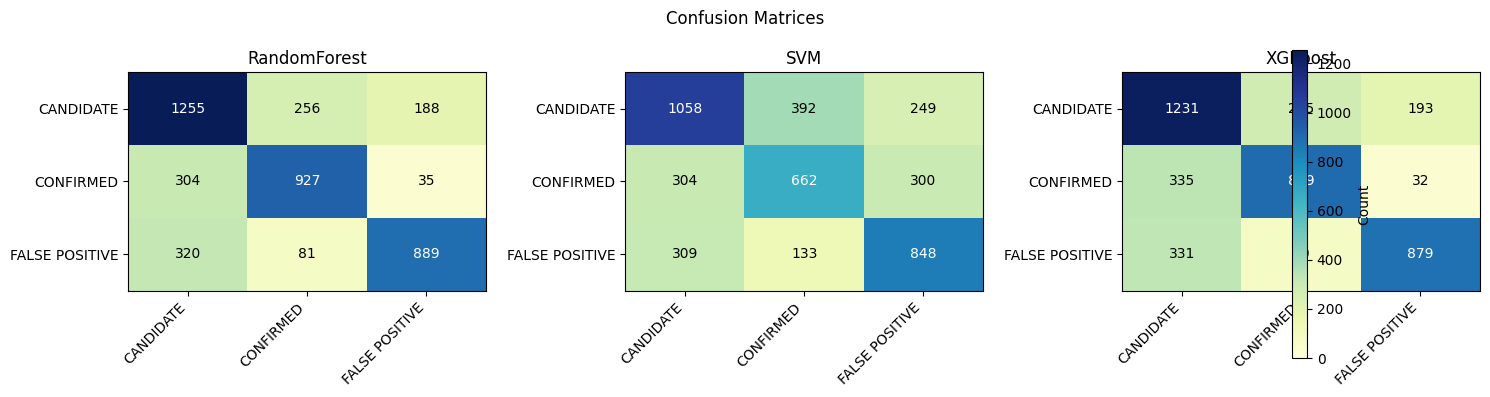

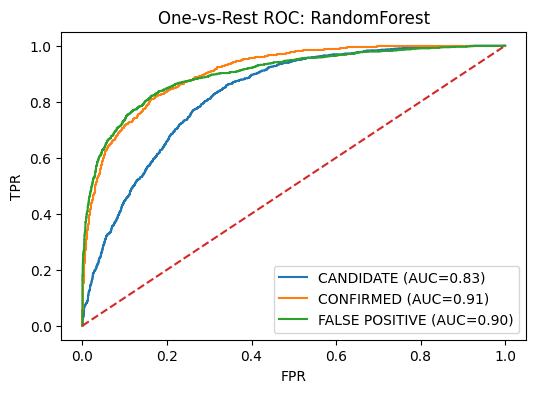

In [9]:
import matplotlib.pyplot as plt
import numpy as np, itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

best_name = max(results.keys(), key=lambda n: results[n]["macro_f1"])
best_model = best_estimators[best_name]
print(f"✅ Selected best model: {best_name}")

labels_enc = np.arange(len(class_names))

# Compute all confusion matrices
names = list(results.keys())
cms = []
for n in names:
    est = best_estimators[n]
    y_pred_enc = est.predict(X_test)
    cms.append(confusion_matrix(y_test_enc, y_pred_enc, labels=labels_enc))

cm_global_max = np.max([cm.max() for cm in cms])

cmap = plt.cm.YlGnBu
fig, axes = plt.subplots(1, len(names), figsize=(5*len(names), 4))
axes_iter = axes if isinstance(axes, np.ndarray) else [axes]

for ax, n, cm in zip(axes_iter, names, cms):
    im = ax.imshow(cm, aspect='auto', cmap=cmap, vmin=0, vmax=cm_global_max)
    ax.set_title(n)
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    thresh = cm_global_max/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="w" if cm[i, j] > thresh else "black")

cbar = fig.colorbar(im, ax=axes_iter, fraction=0.046, pad=0.04)
cbar.set_label("Count")
plt.suptitle("Confusion Matrices")
plt.tight_layout()
plt.show()

# ROC for best model (if probabilities exist)
def get_proba(estimator, X):
    if hasattr(estimator, "predict_proba"):
        try: return estimator.predict_proba(X)
        except Exception: return None
    try:
        preproc = estimator.named_steps['pre']; clf = estimator.named_steps['clf']
        Xp = preproc.transform(X)
        if hasattr(clf, "predict_proba"): return clf.predict_proba(Xp)
    except Exception:
        return None

proba = get_proba(best_model, X_test)
if proba is not None:
    y_bin = label_binarize(y_test_enc, classes=labels_enc)
    plt.figure(figsize=(6,4))
    for i, lab in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
        plt.plot(fpr, tpr, label=f"{lab} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"One-vs-Rest ROC: {best_name}")
    plt.legend()
    plt.show()
else:
    print(f"{best_name}: probabilities unavailable; skipping ROC.")


## Handling Class Imbalance (SMOTE)

We inline preprocessing inside `imblearn.Pipeline` (no nested pipelines). Results are compared on macro-F1.


In [10]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np, pandas as pd

try:
    FAST
except NameError:
    FAST = True

cv2 = StratifiedKFold(n_splits=(3 if FAST else 5), shuffle=True, random_state=42)

def n_iter_from_space(param_grid: dict, fast_cap: int = 4, slow_cap: int = 6, fast=True) -> int:
    if not param_grid: return 1
    sizes = []
    for v in param_grid.values():
        try: sizes.append(len(v))
        except TypeError: sizes.append(1)
    total = int(np.prod(sizes)) if sizes else 1
    return min((fast_cap if fast else slow_cap), max(1, total))

rf_imb = ImbPipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", RobustScaler()),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(random_state=42))
])
rf_imb_params = {"clf__n_estimators": [200] if FAST else [200, 400],
                 "clf__max_depth": [None, 12]}

svm_imb = ImbPipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", RobustScaler()),
    ("smote", SMOTE(random_state=42)),
    ("clf", SVC(kernel='rbf', probability=True, random_state=42))
])
svm_imb_params = {"clf__C": [0.5, 1, 5], "clf__gamma": ["scale","auto"]}

imb_results = {}
imb_best = {}

for name, (pipe, params) in {"RF+SMOTE": (rf_imb, rf_imb_params), "SVM+SMOTE": (svm_imb, svm_imb_params)}.items():
    print(f"\n=== Tuning {name} ===")
    n_iter = n_iter_from_space(params, fast=FAST)
    search = RandomizedSearchCV(pipe, params, n_iter=n_iter,
                                scoring="f1_macro", n_jobs=-1, cv=cv2,
                                random_state=42, verbose=1, refit="f1_macro",
                                error_score="raise")
    search.fit(X_train, y_train_enc)
    imb_best[name] = search.best_estimator_
    y_pred_enc = search.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred_enc)
    f1m = f1_score(y_test_enc, y_pred_enc, average='macro')
    imb_results[name] = {"accuracy": acc, "macro_f1": f1m, "best_params": search.best_params_}
    print(f"Best: {search.best_params_} | Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f}")

imb_summary = pd.DataFrame.from_dict(imb_results, orient="index").sort_values("macro_f1", ascending=False)
display(imb_summary)



=== Tuning RF+SMOTE ===
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best: {'clf__n_estimators': 200, 'clf__max_depth': None} | Accuracy: 0.7168 | Macro-F1: 0.7204

=== Tuning SVM+SMOTE ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best: {'clf__gamma': 'auto', 'clf__C': 5} | Accuracy: 0.6042 | Macro-F1: 0.6008


,accuracy,macro_f1,best_params
RF+SMOTE,0.716804,0.720404,"{'clf__n_estimators': 200, 'clf__max_depth': N..."
SVM+SMOTE,0.604230,0.600779,"{'clf__gamma': 'auto', 'clf__C': 5}"


## Feature Importance and Explainability

Permutation importance on the full pipeline and SHAP bar charts for tree models.


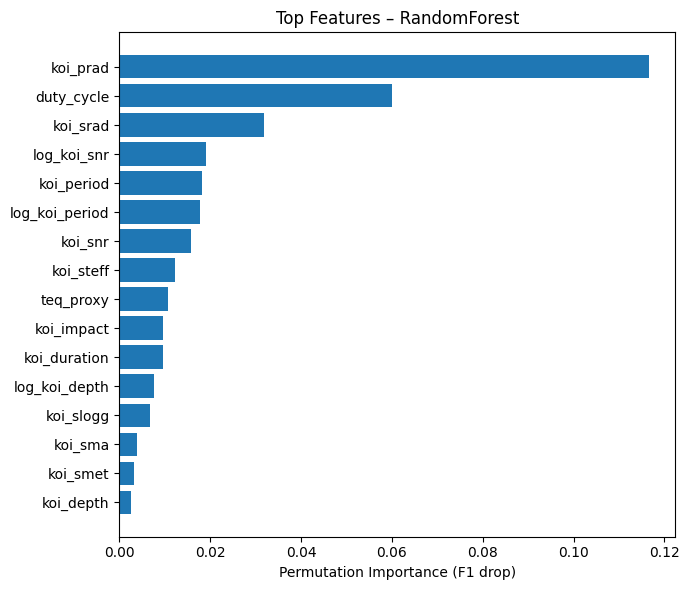

/Users/danieluzumaki/Desktop/Personal/Proyectos_y_Hackatones/API-NASA-SpaceApp-2025/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


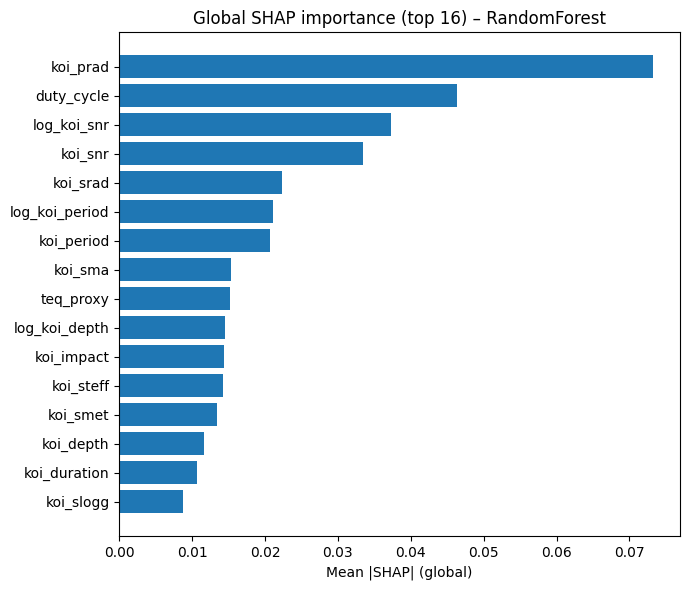

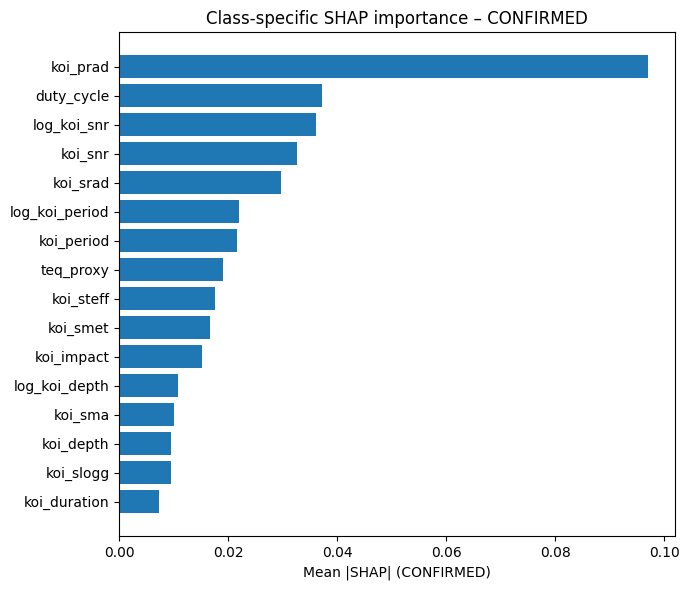

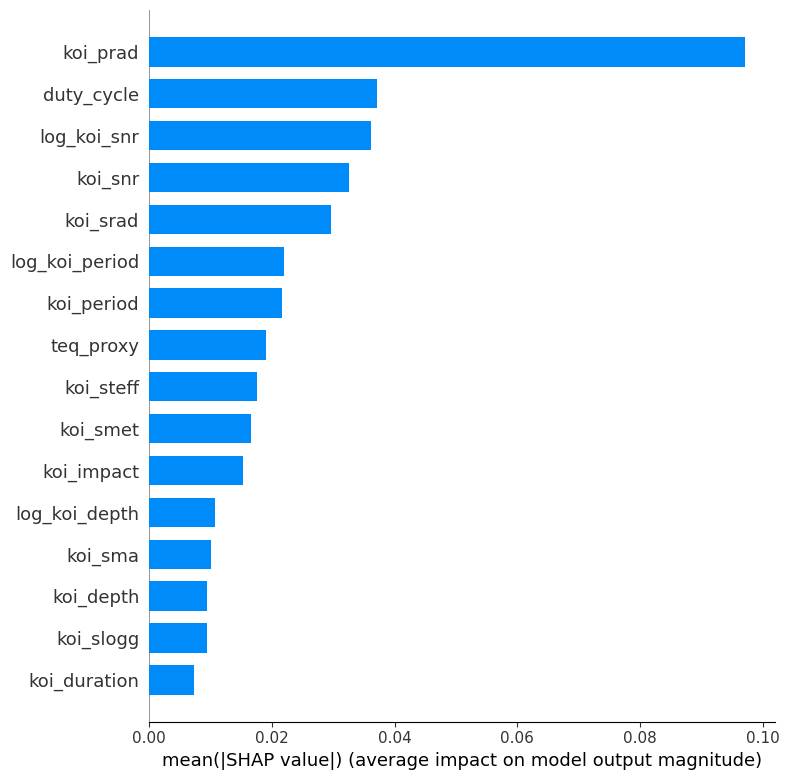

In [11]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

try:
    best_model
    best_name
except NameError:
    best_name = max(results.keys(), key=lambda n: results[n]["macro_f1"])
    best_model = best_estimators[best_name]

is_pipe = isinstance(best_model, Pipeline)
preproc = best_model.named_steps["pre"] if is_pipe and "pre" in best_model.named_steps else None
clf     = best_model.named_steps["clf"] if is_pipe and "clf" in best_model.named_steps else best_model

feat_names = list(X_train.columns)

# Sample and align labels by position
X_test_sample = X_test.sample(min(2000, len(X_test)), random_state=42)
pos = X_test.index.get_indexer(X_test_sample.index)
pos = pos[pos >= 0]
y_test_sample_enc = np.asarray(y_test_enc)[pos]

# Permutation importance on the *full* pipeline
perm = permutation_importance(best_model, X_test_sample, y_test_sample_enc,
                              n_repeats=5, random_state=42, scoring='f1_macro')
importances = perm.importances_mean
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(7,6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [feat_names[i] for i in indices][::-1])
plt.xlabel("Permutation Importance (F1 drop)")
plt.title(f"Top Features – {best_name}")
plt.tight_layout()
plt.show()

# SHAP bars
try:
    import shap
    is_tree_model = (
        hasattr(clf, "feature_importances_")
        or "XGB" in best_name.upper()
        or "FOREST" in best_name.upper()
        or "BOOST" in best_name.upper()
    )
    if not is_tree_model:
        print("SHAP: Skipping (not a tree-based model).")
    else:
        X_proc = preproc.transform(X_test_sample) if preproc is not None else X_test_sample.values
        X_proc_small = X_proc if X_proc.shape[0] <= 2000 else X_proc[:2000]

        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_proc_small)

        if isinstance(shap_values, list):
            sv = np.stack([np.asarray(v) for v in shap_values], axis=-1)
        else:
            sv = np.asarray(shap_values)
            if sv.ndim == 2: sv = sv[..., np.newaxis]
            elif sv.ndim != 3: raise ValueError(f"Unexpected SHAP array shape: {sv.shape}")

        n_samples, n_features, n_classes = sv.shape
        topk = min(20, n_features)

        global_imp = np.nanmean(np.abs(sv), axis=(0, 2))
        idx = np.argsort(global_imp)[::-1][:topk]
        plt.figure(figsize=(7,6))
        plt.barh(range(topk), global_imp[idx][::-1])
        plt.yticks(range(topk), [feat_names[i] for i in idx][::-1])
        plt.xlabel("Mean |SHAP| (global)")
        plt.title(f"Global SHAP importance (top {topk}) – {best_name}")
        plt.tight_layout()
        plt.show()

        try:
            target_idx = int(np.where(class_names == "CONFIRMED")[0][0])
            target_title = "CONFIRMED"
        except Exception:
            target_idx = 0; target_title = f"class {target_idx}"

        per_class_imp = np.nanmean(np.abs(sv[:, :, target_idx]), axis=0)
        idx_c = np.argsort(per_class_imp)[::-1][:topk]
        plt.figure(figsize=(7,6))
        plt.barh(range(topk), per_class_imp[idx_c][::-1])
        plt.yticks(range(topk), [feat_names[i] for i in idx_c][::-1])
        plt.xlabel(f"Mean |SHAP| ({target_title})")
        plt.title(f"Class-specific SHAP importance – {target_title}")
        plt.tight_layout()
        plt.show()

        try:
            class_sv = shap_values[target_idx] if isinstance(shap_values, list) else sv[:, :, target_idx]
            shap.summary_plot(class_sv, X_proc_small, feature_names=feat_names,
                              plot_type="bar", max_display=topk, show=True)
        except Exception as e:
            print("SHAP summary (bar) skipped:", e)

except Exception as e:
    print("SHAP skipped:", e)


## Save Best Model + Metadata

We persist the full pipeline and the exact feature order (including SNR or SNR proxy), plus class labels.


In [12]:
import os, json, joblib
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

best_name = max(results.keys(), key=lambda n: results[n]["macro_f1"])
best_model = best_estimators[best_name]

feature_columns = list(X_train.columns)
class_labels    = list(class_names)

joblib.dump(best_model, os.path.join(ARTIFACTS_DIR, "exoplanet_best_model.joblib"))
with open(os.path.join(ARTIFACTS_DIR, "exoplanet_feature_columns.json"), "w") as f:
    json.dump(feature_columns, f)
with open(os.path.join(ARTIFACTS_DIR, "exoplanet_class_labels.json"), "w") as f:
    json.dump(class_labels, f)
with open(os.path.join(ARTIFACTS_DIR, "exoplanet_metadata.json"), "w") as f:
    json.dump({"best_model_name": best_name,
               "n_features": len(feature_columns),
               "labels": class_labels,
               "created": "2025-10-05T20:49:33.128163Z"
               }, f, indent=2)

print("Saved artifacts to ./artifacts")
print("Features:", feature_columns)


Saved artifacts to ./artifacts
Features: ['koi_depth', 'koi_duration', 'koi_impact', 'koi_period', 'koi_prad', 'koi_slogg', 'koi_sma', 'koi_smet', 'koi_snr', 'koi_srad', 'koi_steff', 'duty_cycle', 'log_koi_period', 'log_koi_depth', 'log_koi_snr', 'teq_proxy']


## Final Summary

- SNR: real (`koi_snr`) if present, otherwise **`snr_proxy`** (with log transforms).  
- Mission removed; unified labels; 
- Macro-F1 model selection; SMOTE option; permutation + SHAP explainability.  
- Artifacts saved and inference examples provided.


## Inference Example + Debug

Predict on example dicts. If training used **real SNR**, we fill `koi_snr` (+ `log_koi_snr`).  
If training used the **proxy**, we fill `snr_proxy` (+ `log_snr_proxy`).  
(You can omit any field; the imputer will fill NaNs—but providing engineered features yields better behavior.)


## Load Artifacts

In [14]:
import json, joblib, numpy as np, pandas as pd
from pathlib import Path

ARTIFACTS_DIR = Path("artifacts")

best_model = joblib.load(ARTIFACTS_DIR / "exoplanet_best_model.joblib")
feature_columns = json.loads((ARTIFACTS_DIR / "exoplanet_feature_columns.json").read_text())
class_labels    = json.loads((ARTIFACTS_DIR / "exoplanet_class_labels.json").read_text())

print("Loaded model and metadata.")
print("First 20 expected features:", feature_columns[:20], "...")

Loaded model and metadata.
First 20 expected features: ['koi_depth', 'koi_duration', 'koi_impact', 'koi_period', 'koi_prad', 'koi_slogg', 'koi_sma', 'koi_smet', 'koi_snr', 'koi_srad', 'koi_steff', 'duty_cycle', 'log_koi_period', 'log_koi_depth', 'log_koi_snr', 'teq_proxy'] ...


## Helpers: prediction + SNR injection

In [15]:
def predict_with_debug(model, feature_columns, class_labels, params: dict, show_top=14):
    X_infer = pd.DataFrame([params], dtype=float).reindex(columns=feature_columns)
    recognized = [c for c in feature_columns if c in params]
    unknown    = [k for k in params.keys() if k not in feature_columns]
    missing    = X_infer.columns[X_infer.iloc[0].isna()].tolist()

    print(f"Recognized features: {len(recognized)}/{len(feature_columns)}")
    if recognized:
        print("  •", ", ".join(recognized[:show_top]) + (" ..." if len(recognized) > show_top else ""))
    if unknown:
        print(f"WARNING: {len(unknown)} provided keys are NOT in training features.")
        print("  •", ", ".join(unknown[:show_top]) + (" ..." if len(unknown) > show_top else ""))
    print(f"Missing (imputed): {len(missing)}")
    if missing:
        print("  •", ", ".join(missing[:show_top]) + (" ..." if len(missing) > show_top else ""))

    y_idx = int(model.predict(X_infer)[0])
    label = class_labels[y_idx]
    print(f"\nPrediction: {label} (index {y_idx})")

    try:
        proba = model.predict_proba(X_infer)[0]
        ordered = sorted(zip(class_labels, proba), key=lambda t: t[1], reverse=True)
        print("\nClass probabilities:")
        for lbl, p in ordered:
            print(f"  {lbl:>15s}: {p: .3f}")
    except Exception:
        print("(Model has no predict_proba.)")
    return label


def has(col: str) -> bool:
    return col in feature_columns


def add_snr_fields(d: dict, snr_value: float) -> dict:
    """
    If the trained model expects real SNR, add koi_snr (+ log_koi_snr).
    Otherwise, if it expects a proxy, add snr_proxy (+ log_snr_proxy).
    If base fields are present, proxy is computed from them; else use snr_value as fallback.
    """
    d = dict(d)
    if has("koi_snr"):
        d["koi_snr"] = snr_value
        if has("log_koi_snr"):
            d["log_koi_snr"] = np.log10(snr_value) if snr_value > 0 else np.nan
    elif has("snr_proxy"):
        if {"koi_depth", "koi_duration", "koi_period"}.issubset(d.keys()):
            proxy = d["koi_depth"] * np.sqrt(d["koi_duration"] / (d["koi_period"] * 24.0))
        else:
            proxy = snr_value  # fallback if base fields aren't present
        d["snr_proxy"] = proxy
        if has("log_snr_proxy"):
            d["log_snr_proxy"] = np.log10(proxy) if proxy > 0 else np.nan
    return d


## False Positive-like example

In [16]:
# Base variables (FP-like: grazing, deep, very short period)
koi_period_fp   = 0.50
koi_duration_fp = 0.35
koi_depth_fp    = 30000.0
koi_impact_fp   = 0.98
koi_prad_fp     = 20.0
koi_slogg_fp    = 4.4
koi_sma_fp      = 0.012
koi_smet_fp     = 0.0
koi_srad_fp     = 1.0
koi_steff_fp    = 6000.0

# Engineered features from the variables
duty_cycle_fp     = koi_duration_fp / (koi_period_fp * 24.0)
log_koi_period_fp = np.log10(koi_period_fp) if koi_period_fp > 0 else np.nan
log_koi_depth_fp  = np.log10(koi_depth_fp) if koi_depth_fp > 0 else np.nan
teq_proxy_fp      = koi_steff_fp  # simple proxy (use refined if your FE expects it)

# Build dict
fp_base = {
    "koi_period": koi_period_fp,
    "koi_duration": koi_duration_fp,
    "koi_depth": koi_depth_fp,
    "koi_impact": koi_impact_fp,
    "koi_prad": koi_prad_fp,
    "koi_slogg": koi_slogg_fp,
    "koi_sma": koi_sma_fp,
    "koi_smet": koi_smet_fp,
    "koi_srad": koi_srad_fp,
    "koi_steff": koi_steff_fp,
    "duty_cycle": duty_cycle_fp,
    "log_koi_period": log_koi_period_fp,
    "log_koi_depth": log_koi_depth_fp,
    "teq_proxy": teq_proxy_fp,
}

# Add SNR (real or proxy) according to trained features
fp = add_snr_fields(fp_base, snr_value=80.0)

print("FP example — SNR fields present in model:",
      [c for c in ["koi_snr", "log_koi_snr", "snr_proxy", "log_snr_proxy"] if c in feature_columns])

_ = predict_with_debug(best_model, feature_columns, class_labels, fp)

FP example — SNR fields present in model: ['koi_snr', 'log_koi_snr']
Recognized features: 16/16
  • koi_depth, koi_duration, koi_impact, koi_period, koi_prad, koi_slogg, koi_sma, koi_smet, koi_snr, koi_srad, koi_steff, duty_cycle, log_koi_period, log_koi_depth ...
Missing (imputed): 0

Prediction: FALSE POSITIVE (index 2)

Class probabilities:
   FALSE POSITIVE:  0.804
        CANDIDATE:  0.135
        CONFIRMED:  0.061


## Confirmed-like example

In [17]:
# Base variables (CONF-like: shallower, longer period)
koi_period   = 12.0
koi_duration = 3.5
koi_depth    = 600.0
koi_impact   = 0.20
koi_prad     = 2.1
koi_slogg    = 4.4
koi_sma      = 0.10
koi_smet     = 0.0
koi_srad     = 1.0
koi_steff    = 5700.0

# Engineered features
duty_cycle     = koi_duration / (koi_period * 24.0)
log_koi_period = np.log10(koi_period) if koi_period > 0 else np.nan
log_koi_depth  = np.log10(koi_depth)  if koi_depth  > 0 else np.nan

# teq_proxy options:
teq_proxy_simple = koi_steff
AU_over_Rsun = 215.032
a_rs = AU_over_Rsun * (koi_sma / koi_srad) if (koi_srad > 0) else np.nan
teq_proxy_refined = (koi_steff / np.sqrt(2.0 * a_rs)) if (np.isfinite(a_rs) and a_rs > 0) else teq_proxy_simple

# Build dict (choose the proxy your FE expects)
conf_base = {
    "koi_period": koi_period,
    "koi_duration": koi_duration,
    "koi_depth": koi_depth,
    "koi_impact": koi_impact,
    "koi_prad": koi_prad,
    "koi_slogg": koi_slogg,
    "koi_sma": koi_sma,
    "koi_smet": koi_smet,
    "koi_srad": koi_srad,
    "koi_steff": koi_steff,
    "duty_cycle": duty_cycle,
    "log_koi_period": log_koi_period,
    "log_koi_depth": log_koi_depth,
    "teq_proxy": teq_proxy_refined,  # or teq_proxy_simple
}

# Add SNR (real or proxy) according to trained features
confirmed = add_snr_fields(conf_base, snr_value=12.0)

print("CONF example — SNR fields present in model:",
      [c for c in ["koi_snr", "log_koi_snr", "snr_proxy", "log_snr_proxy"] if c in feature_columns])

_ = predict_with_debug(best_model, feature_columns, class_labels, confirmed)


CONF example — SNR fields present in model: ['koi_snr', 'log_koi_snr']
Recognized features: 16/16
  • koi_depth, koi_duration, koi_impact, koi_period, koi_prad, koi_slogg, koi_sma, koi_smet, koi_snr, koi_srad, koi_steff, duty_cycle, log_koi_period, log_koi_depth ...
Missing (imputed): 0

Prediction: CONFIRMED (index 1)

Class probabilities:
        CONFIRMED:  0.419
        CANDIDATE:  0.408
   FALSE POSITIVE:  0.174
